# ch 3. text classification

이미지와 마찬가지로 텍스트 데이터도 분류가 가장 기본적인 테스크입니다. 긍정적인 리뷰와 부정적인 리뷰로 분류하는 모델을 만들어보겠습니다.

## 사전 작업

### 데이터 셋 준비

In [1]:
import pandas as pd

train_df = pd.read_csv("./data/naver_reviews_train.csv")
val_df = pd.read_csv("./data/naver_reviews_test.csv")

train_df = train_df.dropna()
val_df = val_df.dropna()

### tokenizer 준비

In [2]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("./data/tokenizer.json")

In [3]:
tokenizer.encode("최고의 영화!").tokens

['최고의', '영화', '!']

## 데이터 전처리

텍스트 데이터 셋도 이미지 데이터 셋과 마찬가지로 dataset과 dataloader가 필요합니다. 그리고 텍스트를 텐서로 변환하는 전처리 로직도 필요합니다. 우선 간단하게 dataset과 dataloader를 만들어주겠습니다.

### Dataset, DataLoader

In [4]:
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, corpus_df, transform=None):
        self.corpus_df = corpus_df
        self.transform = transform

    def __len__(self):
        return len(self.corpus_df)

    def __getitem__(self, idx):
        text, label = self.corpus_df.iloc[idx]
        return text, label 

In [5]:
train_dataset = CustomTextDataset(train_df)
val_dataset = CustomTextDataset(val_df)

In [6]:
train_dataset[0]

('아 더빙.. 진짜 짜증나네요 목소리', 0)

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [8]:
train_iterator = iter(train_dataloader)
batch = next(train_iterator)

In [9]:
batch

[('불만제로 별점 테러 노답이다 진짜ㅋㅋ 그 동안 대기업을 상대로도 부당함을 소비자에게 알려준 멋진 프로그램...폐지안했으면ㅜㅜ',
  '재밌어요귀엽고볼만해요',
  "마지막 소년의 돌은 '티오노리코' 사랑을 전하기 위함이었다.",
  '정말 감동적이예요! 부모님 모시고 다시 꼭 보고 싶네요 ㅠㅠ'),
 tensor([1, 1, 1, 1])]

텍스트 데이터의 특징은 문장들 간에 길이가 다르다는 것입니다. 즉, 문장을 토큰화화면 길이가 달라집니다. 배치에 들어있는 텍스트 데이터를 토큰화 해보겠습니다.

In [10]:
import torch

def tokenize(text):
    tokens = tokenizer.encode(text).ids
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    return token_tensor

In [11]:
batch_text = batch[0]
batch_tensor = [tokenize(x) for x in batch_text]

In [12]:
batch_tensor

[tensor([1144, 2589, 8788, 5576, 8017, 7464, 4902, 4892, 4878,  219, 7667,  544,
         2659, 2628, 2588, 1276, 5000, 2639, 1138, 2970, 5648, 1345, 2991, 2598,
         4997, 6257, 2945, 5429, 6693, 4877, 8725, 2723, 6669, 5362]),
 tensor([5396, 3170, 3187, 2602, 2831, 2589, 5283]),
 tensor([4951, 8674, 2578,  599, 2608,    5, 2318, 2661, 2821, 2599, 2919,    5,
         6172, 1805, 5071, 1717, 5714, 4918,    7]),
 tensor([4888, 5604, 5966,    4, 8614,  974, 6280, 4943,  301, 4911, 7488, 5035])]

### Padding

위 예시에서 data loader가 batch size만큼 문장을 읽어왔습니다. 그리고 이를 토큰화 하였는데, 문장마다 길이가 다르기 때문에 토큰 개수도 다릅니다. 이를 하나의 텐서로 묶어주기 위해서는 가장 긴 문장의 길이를 기준으로 나머지 문장들에 패딩을 추가해주어야 합니다. 

먼저 패딩에 해당하는 토큰을 확인해보겠습니다.

In [13]:
vocabs = tokenizer.get_vocab()
pad_token = vocabs["[PAD]"]
print("Pad token: ", pad_token)

Pad token:  0


torch에 내장되어 있는 pad_sequence 기능을 이용해서 패딩을 채워보겠습니다.

In [16]:
from torch.nn.utils.rnn import pad_sequence

batch_padded = pad_sequence(batch_tensor, padding_value=pad_token)

In [17]:
batch_padded

tensor([[1144, 5396, 4951, 4888],
        [2589, 3170, 8674, 5604],
        [8788, 3187, 2578, 5966],
        [5576, 2602,  599,    4],
        [8017, 2831, 2608, 8614],
        [7464, 2589,    5,  974],
        [4902, 5283, 2318, 6280],
        [4892,    0, 2661, 4943],
        [4878,    0, 2821,  301],
        [ 219,    0, 2599, 4911],
        [7667,    0, 2919, 7488],
        [ 544,    0,    5, 5035],
        [2659,    0, 6172,    0],
        [2628,    0, 1805,    0],
        [2588,    0, 5071,    0],
        [1276,    0, 1717,    0],
        [5000,    0, 5714,    0],
        [2639,    0, 4918,    0],
        [1138,    0,    7,    0],
        [2970,    0,    0,    0],
        [5648,    0,    0,    0],
        [1345,    0,    0,    0],
        [2991,    0,    0,    0],
        [2598,    0,    0,    0],
        [4997,    0,    0,    0],
        [6257,    0,    0,    0],
        [2945,    0,    0,    0],
        [5429,    0,    0,    0],
        [6693,    0,    0,    0],
        [4877,

패딩을 채워보면 하나의 열에 문장 하나의 토큰 값들이 담기게 됩니다. 가장 긴 문장의 길이만큼 나머지 문장들에는 패딩이 채워진 모습을 확인할 수 있습니다.

### collate_fn

이렇게 텍스트를 토큰화 하고, 배치 단위로 패딩을 채워넣었습니다. 그런데 패딩을 채우기 위해서는 배치 내에서 가장 길이가 긴 문장의 토큰 수를 알아야 합니다. 즉, 데이터 셋에서 데이터 로더가 배치 사이즈만큼 데이터를 가져오는 시점에 텍스트를 토큰화하고, 패딩을 채우는 작업을 수행해주어야 합니다. 이러한 작업을 수행해주는 역할을 묶어주는 함수, collate_fn이라고 부릅니다.

collate 함수 안에서는 데이터를 토큰화 해주고, 패딩을 채워주는 작업을 진행합니다. 이 때, 특정 문장의 길이가 지나치게 긴 경우를 예방하기 위해 최대 토큰 길이 값을 지정해줍니다.

In [18]:
MAX_TOKENS = 256 
BATCH_SIZE = 128 

In [19]:
def collate_fn(batch):
    def _tokenize(text):
        tokens = tokenizer.encode(text).ids
        tokens = tokens[:MAX_TOKENS]
        token_tensor = torch.tensor(tokens, dtype=torch.long)
        return token_tensor
    
    batch_text = [x[0] for x in batch] 
    batch_label = torch.tensor([x[1] for x in batch], dtype=torch.long)
    batch_tokens = [_tokenize(x) for x in batch_text]
    batch_padded = pad_sequence(batch_tokens, padding_value=pad_token)
    return batch_padded, batch_label

In [20]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    collate_fn=collate_fn
)

In [21]:
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
)

In [22]:
train_iterator = iter(train_dataloader)
batch = next(train_iterator)

In [23]:
print(batch)

(tensor([[6432, 1501, 9111,  ..., 6218, 6219, 5520],
        [7026, 2593, 5972,  ...,    1, 5098, 8993],
        [1122, 4877, 8005,  ..., 4876, 3297, 2864],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]]), tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 0, 0, 0]))


## 모델 학습

### 모델 작성

이제 텍스트를 분류하는 딥러닝 모델을 만들어보겠습니다. 모델의 구조는 아래와 같습니다.

![Untitled Diagram-Page-4.drawio.png](https://storage.googleapis.com/data-analytics-camp/week12_deeplearning_nlp/1.png)

먼저 토큰화 한 문장을 embedding layer를 통과시켜 각 토큰별 임베딩 벡터를 가져옵니다. 각 토큰별로 128 차원의 임베딩을 갖도록 하고, 현재 tokenizer는 총 8000개의 토큰을 가지고 있으므로 임베딩 레이어는 8000 X 128이 됩니다. 이제 문장에 포함된 토큰만 가져온 뒤, 평균을 냅니다. 그리고 이를 리니어 레이어를 하나 통과시킨 뒤, 학습을 시켜보겠습니다. 

In [24]:
from torch import nn

class TextClassification(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.fc = nn.Linear(embedding_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=0)
        x = self.fc(x)
        return x

In [25]:
VOCAB_SIZE = len(tokenizer.get_vocab())
EMBEDDING_DIM = 128
OUTPUT_DIM = 2

In [26]:
model = TextClassification(
    vocab_size=VOCAB_SIZE, 
    embedding_dim=EMBEDDING_DIM,
    output_dim=OUTPUT_DIM
)

In [27]:
model

TextClassification(
  (embedding): Embedding(10000, 128)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

### 학습 코드 준비

기존 모델 학습에 사용했던 코드를 재사용하여 학습을 진행해보겠습니다.

In [28]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [29]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [30]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [31]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [32]:
from matplotlib import pyplot as plt
def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

### 하이퍼 파라미터 셋팅 

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 학습

In [34]:
logs = train_validate_model(model)

100%|█████████████████████████████████████████████████| 391/391 [00:03<00:00, 130.01it/s]


epoch 1 train - loss: 0.6049 acc: 0.6986 val - loss: 0.4943 acc: 0.7965


100%|█████████████████████████████████████████████████| 391/391 [00:02<00:00, 131.01it/s]


epoch 2 train - loss: 0.4286 acc: 0.8236 val - loss: 0.4076 acc: 0.8289


100%|█████████████████████████████████████████████████| 391/391 [00:02<00:00, 131.58it/s]


epoch 3 train - loss: 0.3732 acc: 0.8433 val - loss: 0.3841 acc: 0.8341


100%|█████████████████████████████████████████████████| 391/391 [00:02<00:00, 131.83it/s]


epoch 4 train - loss: 0.3514 acc: 0.8519 val - loss: 0.3764 acc: 0.8363


100%|█████████████████████████████████████████████████| 391/391 [00:02<00:00, 131.42it/s]


epoch 5 train - loss: 0.3401 acc: 0.8567 val - loss: 0.3758 acc: 0.839


100%|█████████████████████████████████████████████████| 391/391 [00:03<00:00, 129.75it/s]


epoch 6 train - loss: 0.3327 acc: 0.8593 val - loss: 0.3696 acc: 0.8412


100%|█████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 128.53it/s]


epoch 7 train - loss: 0.3286 acc: 0.861 val - loss: 0.3697 acc: 0.8409


100%|█████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 129.95it/s]


epoch 8 train - loss: 0.3251 acc: 0.8625 val - loss: 0.3756 acc: 0.8402


100%|█████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 130.22it/s]


epoch 9 train - loss: 0.3232 acc: 0.8629 val - loss: 0.3692 acc: 0.8435


100%|█████████████████████████████████████████████████████████████████| 391/391 [00:03<00:00, 127.38it/s]

epoch 10 train - loss: 0.3209 acc: 0.8644 val - loss: 0.3707 acc: 0.8421


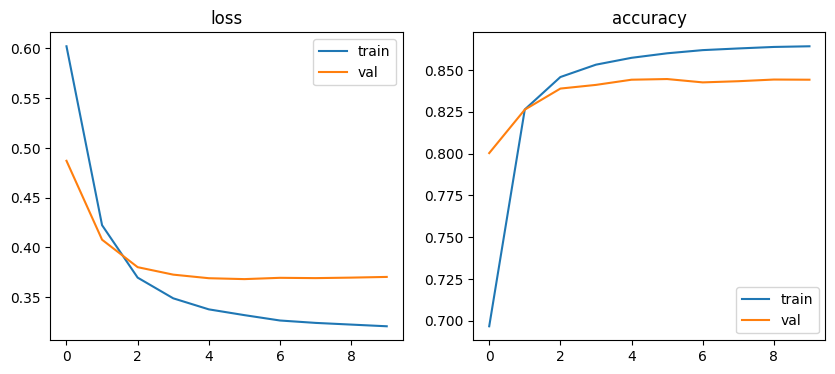

In [377]:
plot_logs(logs)

## 정리

이번 챕터에서는 텍스트 데이터를 DataLoader를 이용해서 텐서로 변환하고, Embedding Layer와 Fully Connected Layer를 이용해서 분류 모델을 학습시키는 작업을 수행해보았습니다. 그 결과 84% 정도의 성능을 얻을 수 있었습니다.